## Homework: Week 3 - Customer Segmentation

### Part 5: DBSCAN on Mall Customers
- Use the same 2 features: Annual Income (k\$) and Spending Score (1-100) (scaled).
- Run DBSCAN (try to find the optimal $\epsilon$ using the k-Distance Graph with MinPts calculated using the rule of thumb in the slide).
- Pick one $\epsilon$ in the knee area that gives a reasonable number of clusters plus maybe some noise.
- Plot customers:
  - x-axis: Income
  - y-axis: Spending Score
  - Color by DBSCAN cluster, noise as black.
- Create a small table: for each cluster, show mean Age, Annual Income, Spending Score and cluster size. Compare these clusters with those from K-Means.
- Identify some outliers and give comments about them.
- Give some comments comparing K‑Means vs DBSCAN for this dataset:
  - Which is easier to tune?
  - Which gives more interpretable segments for marketing?
  - Which would you use for this segmentation task, and why?


### Part 1: Exploration & Preprocessing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv")

df = df.drop(columns=['CustomerID'])

print(df.head())
print(df.describe())
print(df.info())

    Genre  Age  Annual Income (k$)  Spending Score (1-100)
0    Male   19                  15                      39
1    Male   21                  15                      81
2  Female   20                  16                       6
3  Female   23                  16                      77
4  Female   31                  17                      40
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (to

#### Simple Scatter plot to visualize

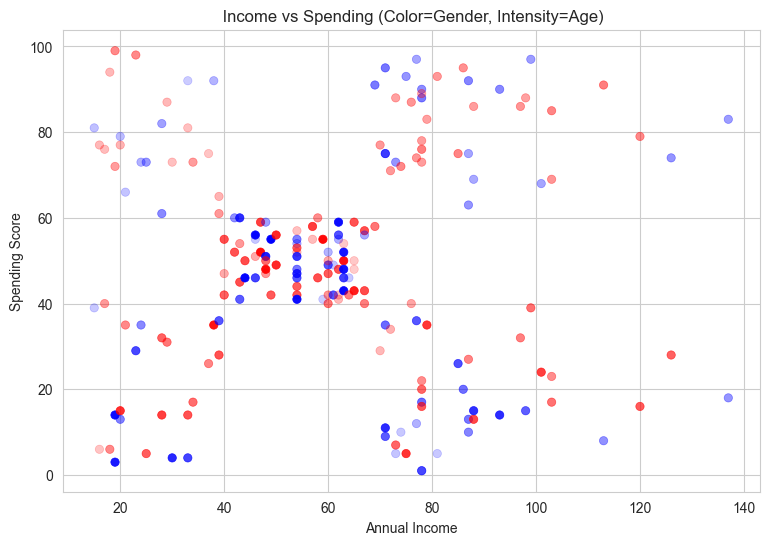

In [11]:
#convert gender to colors
gender_colors = {'Male': 'blue', 'Female': 'red'}
colors = df['Genre'].map(gender_colors)

#opacity by age
age_min = df['Age'].min()
age_max = df['Age'].max()

alphas = 0.2 + 0.8 * ((df['Age'] - age_min) / (age_max - age_min))

plt.figure(figsize=(9, 6))
plt.scatter(
    x=df['Annual Income (k$)'],
    y=df['Spending Score (1-100)'],
    c=colors,
    alpha=alphas,
    linewidth=0.5
)

plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.title(' Income vs Spending (Color=Gender, Intensity=Age)')
plt.show()

### Part 2: Features & Scaling

In [12]:
from sklearn.preprocessing import StandardScaler

X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Part 3: K‑Means: Choose K (Elbow & Silhouette)

Based on the silhouette scores, the optimal number of clusters is `K=5`, since the silhouette score reaches its maximum at this point. The elbow plot also supports this choice: the curve shows a substantial drop up to `K=4`, the decrease becomes much more gradual after `K=5`. Both methods converge to the conclusion that `K=5` provides the best balance between cluster cohesion and separation

### The Elbow Method

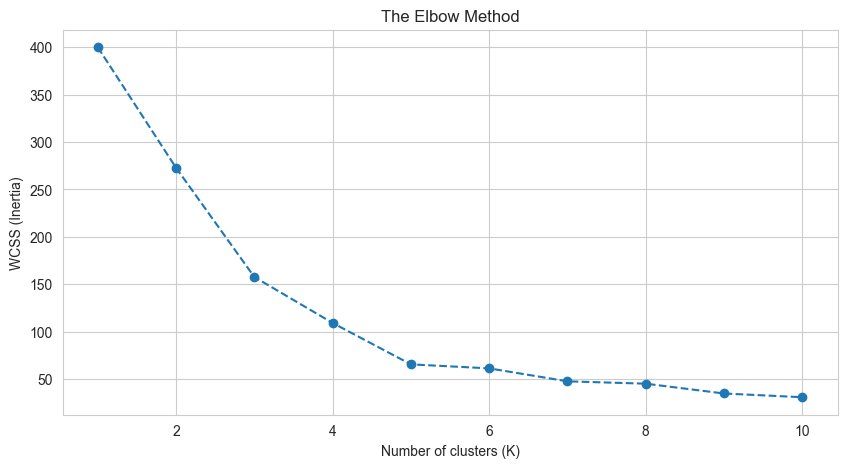

In [21]:
from sklearn.cluster import KMeans

wcss = []
k_range = range(1,11)

for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.show()

### Elbow Method using only `sklearn`

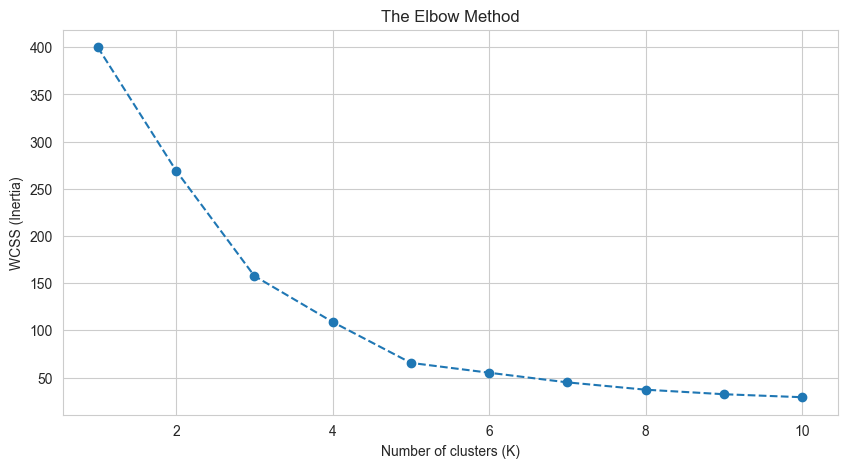

In [23]:
wcss_sk = []
k_range = range(1,11)

for k in k_range:
    km_sk = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=0)
    km_sk.fit(X_scaled)
    wcss_sk.append(km_sk.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(k_range, wcss_sk, marker='o', linestyle='--')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.show()

#### Silhouette Score

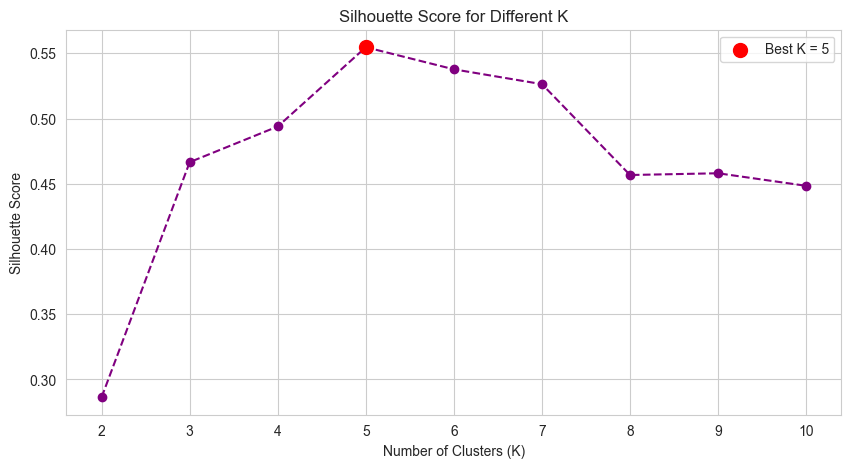

In [26]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
k_range = range(2,11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=10, max_iter=300, random_state=0)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--', color='purple')
plt.title("Silhouette Score for Different K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Silhouette Score")

# Highlight the best K
best_k_idx = np.argmax(silhouette_scores)
best_k = list(k_range)[best_k_idx]
best_score = silhouette_scores[best_k_idx]

plt.scatter(best_k, best_score, color='red', s=100, zorder=5, label=f'Best K = {best_k}')
plt.legend()
plt.show()

### Part 4: Final K‑Means Model (K = 5) & Strategy

In [27]:
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, max_iter=300, random_state=0)
kmeans.fit(X_scaled)

df['Cluster'] = kmeans.labels_

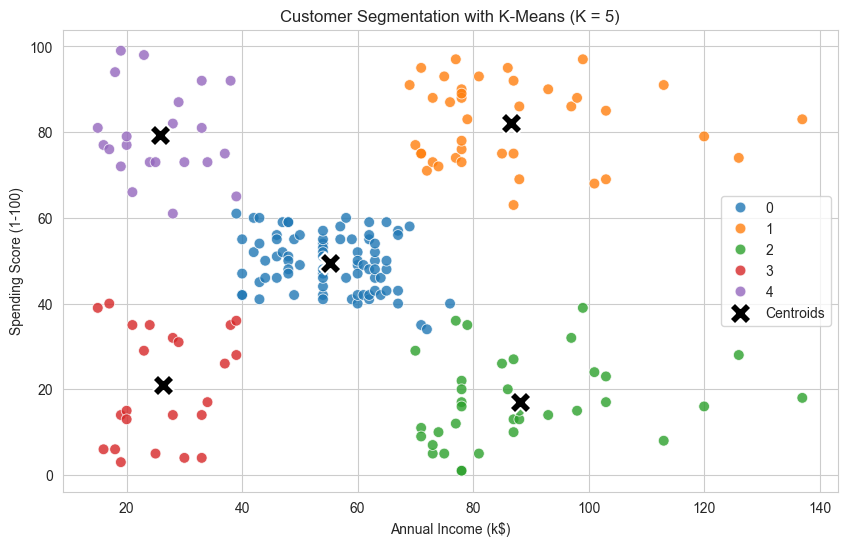

In [31]:
import seaborn as sns

# Plot clusters
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x=df['Annual Income (k$)'],
    y=df['Spending Score (1-100)'],
    hue=df['Cluster'],
    palette="tab10",
    s=60,
    alpha=0.8
)

# Plot centroids rescaled
centroids_scaled = kmeans.cluster_centers_
centroids = scaler.inverse_transform(centroids_scaled)

plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=250,
    c='black',
    marker='X',
    edgecolor='white',
    linewidth=1.5,
    label='Centroids'
)

plt.title("Customer Segmentation with K-Means (K = 5)")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.grid(True)
plt.show()

In [36]:
cluster_summary = df.groupby('Cluster').agg({"Age": "mean",
    "Annual Income (k$)": "mean",
    "Spending Score (1-100)": "mean",
    "Cluster": "count"
}).rename(columns={"Cluster": "Size"})

cluster_summary

,Age,Annual Income (k$),Spending Score (1-100),Size
Cluster,,,,
0,42.716049,55.296296,49.518519,81
1,32.692308,86.538462,82.128205,39
2,41.114286,88.200000,17.114286,35
3,45.217391,26.304348,20.913043,23
4,25.272727,25.727273,79.363636,22


In [37]:
cluster_summary = df.groupby('Cluster').agg({"Age": "median",
    "Annual Income (k$)": "median",
    "Spending Score (1-100)": "median",
    "Cluster": "count"
}).rename(columns={"Cluster": "Size"})

cluster_summary

,Age,Annual Income (k$),Spending Score (1-100),Size
Cluster,,,,
0,46.0,54.0,50.0,81
1,32.0,79.0,83.0,39
2,42.0,85.0,16.0,35
3,46.0,25.0,17.0,23
4,23.5,24.5,77.0,22


**Cluster 0:** Middle-aged, mid-income customers with average spending: target with value-focused products and loyalty incentives.

**Cluster 1:** Young, high-income, very high spenders: promote premium offerings and exclusive experiences.

**Cluster 2:** High-income but very low spenders: emphasize practicality and long-term value to encourage purchases.

**Cluster 3:** Older, low-income, low spenders: focus on budget-friendly essentials and discounts.

**Cluster 4:** Very young, low-income but high spenders: use trend-driven marketing and social media promotions.

### Part 5: DBSCAN on Mall Customers

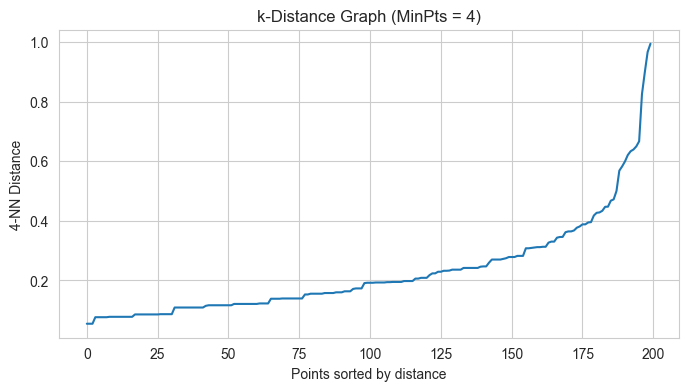

In [45]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

X_db = X_scaled
min_pts = 4

# k = MinPts (4) nearest neighbors
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(X_db)
distances, indices = neighbors_fit.kneighbors(X_db)

# Sort distances for the k-th neighbor
distances_k = np.sort(distances[:, -1])

plt.figure(figsize=(8,4))
plt.plot(distances_k)
plt.title("k-Distance Graph (MinPts = 4)")
plt.xlabel("Points sorted by distance")
plt.ylabel("4-NN Distance")
plt.grid(True)
plt.show()

In [62]:
from sklearn.cluster import DBSCAN

epsilon = 0.3
dbscan = DBSCAN(eps=epsilon, min_samples=min_pts)
db_labels = dbscan.fit_predict(X_db)

df['DBSCAN_Cluster'] = db_labels

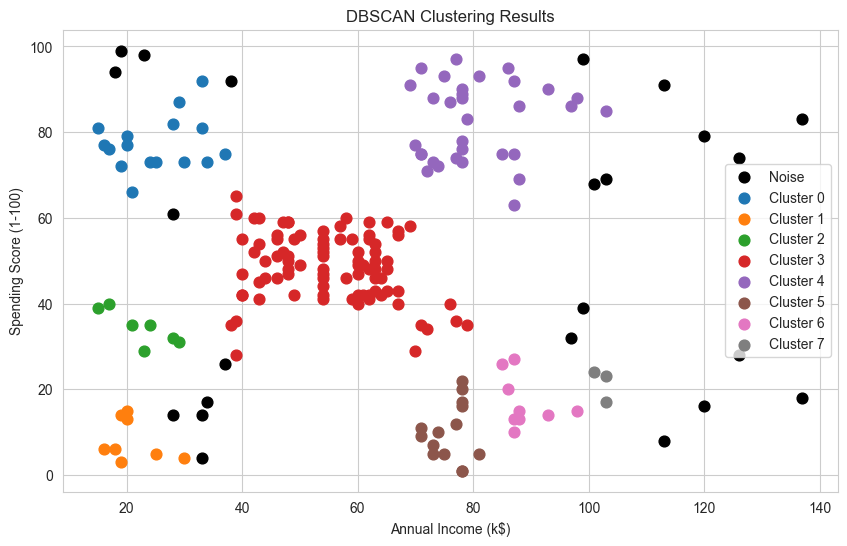

In [63]:
plt.figure(figsize=(10, 6))

# Noise points in black
noise_mask = df['DBSCAN_Cluster'] == -1
plt.scatter(df.loc[noise_mask, 'Annual Income (k$)'],
            df.loc[noise_mask, 'Spending Score (1-100)'],
            c='black', s=60, label='Noise')

# Clusters
clusters = np.unique(db_labels)
clusters = clusters[clusters != -1]  # remove noise

for c in clusters:
    mask = df['DBSCAN_Cluster'] == c
    plt.scatter(df.loc[mask, 'Annual Income (k$)'],
                df.loc[mask, 'Spending Score (1-100)'],
                s=60, label=f"Cluster {c}")

plt.title("DBSCAN Clustering Results")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.legend()
plt.grid(True)
plt.show()

In [64]:
dbscan_summary = df[df['DBSCAN_Cluster'] != -1].groupby("DBSCAN_Cluster").agg({
    "Age": "mean",
    "Annual Income (k$)": "mean",
    "Spending Score (1-100)": "mean",
    "DBSCAN_Cluster": "count"
}).rename(columns={"DBSCAN_Cluster": "Size"})

dbscan_summary

,Age,Annual Income (k$),Spending Score (1-100),Size
DBSCAN_Cluster,,,,
0,23.750000,25.062500,77.312500,16
1,48.375000,20.875000,8.250000,8
2,36.714286,22.428571,34.428571,7
3,42.875000,55.227273,48.579545,88
4,32.812500,80.500000,82.562500,32
5,37.785714,75.928571,10.071429,14
6,46.555556,88.777778,17.000000,9
7,43.000000,102.333333,21.333333,3


In [66]:
outliers = df[df["DBSCAN_Cluster"] == -1]
outliers

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster,DBSCAN_Cluster
7,Female,23,18,94,4,-1
11,Female,35,19,99,4,-1
19,Female,35,23,98,4,-1
24,Female,54,28,14,3,-1
27,Male,35,28,61,4,-1
32,Male,53,33,4,3,-1
34,Female,49,33,14,3,-1
36,Female,42,34,17,3,-1
38,Female,36,37,26,3,-1
41,Male,24,38,92,4,-1
